In [1]:
from __future__ import division
#import sys
import os
import csv
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
# Import datasets, classifiers and performance metrics
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from math import ceil
import util
from threading import Thread
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
#-------------------------------
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline

In [2]:
feature_list = ['n_of_keypoints', 'avg_perc_brightness', 'contrast', 'edge_length1', 'hue1']
man_diff = [
'ILSVRC2012_val_00000001.JPEG',
'ILSVRC2012_val_00000011.JPEG',
'ILSVRC2012_val_00000016.JPEG',
'ILSVRC2012_val_00000021.JPEG',
'ILSVRC2012_val_00000025.JPEG',
'ILSVRC2012_val_00000058.JPEG',
'ILSVRC2012_val_00000068.JPEG',
'ILSVRC2012_val_00000083.JPEG',
'ILSVRC2012_val_00000084.JPEG',
'ILSVRC2012_val_00000087.JPEG',
'ILSVRC2012_val_00000088.JPEG',
'ILSVRC2012_val_00000090.JPEG',
'ILSVRC2012_val_00000100.JPEG',
'ILSVRC2012_val_00000126.JPEG',
'ILSVRC2012_val_00000127.JPEG',
'ILSVRC2012_val_00000133.JPEG',
'ILSVRC2012_val_00000156.JPEG',
'ILSVRC2012_val_00000167.JPEG',
'ILSVRC2012_val_00000182.JPEG',
'ILSVRC2012_val_00000195.JPEG',
'ILSVRC2012_val_00000199.JPEG',
'ILSVRC2012_val_00000200.JPEG',
'ILSVRC2012_val_00000206.JPEG',
'ILSVRC2012_val_00000218.JPEG',
'ILSVRC2012_val_00000225.JPEG',
'ILSVRC2012_val_00000231.JPEG',
'ILSVRC2012_val_00000500.JPEG',
'ILSVRC2012_val_00000520.JPEG',
'ILSVRC2012_val_00000740.JPEG',
'ILSVRC2012_val_00000746.JPEG',
]
nums =[]
for x in man_diff:
    nums.append(int(x[15:23]))

In [3]:
data = []
first_level = []
second_level = []
third_level = []
row_count = 0
with open('all_new_features_hier_norm_top_1.csv', 'rb') as csvfile:
    lines = [line.decode('utf-8-sig') for line in csvfile]

    for row in csv.reader(lines):
        # Remove the headers of csv file
        if row_count is 0:
            row_count = row_count + 1
            continue
        if row_count in nums:
            temp = row[4:7]
            temp.append(row[9])
            temp.append(row[10])
            data.append(temp)                   # changes what features will be used in the premodel. In this array features start at 4th index, and end at the 10th
            first_level.append((row[0],row[1]))     # performance of the first level machine
            second_level.append((row[0],row[2]))    # performance of the second level machine
            third_level.append((row[0],row[3]))     # performance of the third level machine
        row_count = row_count + 1
        if row_count > 1000:
            break

In [4]:
row

['ILSVRC2012_val_00001000.JPEG',
 '1',
 '0',
 '0',
 '0.1696358895785899',
 '-0.22715225702965375',
 '-0.3267070367443663',
 '-0.32707747322971165',
 '-0.1680358998241349',
 '-0.010860929933379813',
 '-0.29067509704717026']

In [5]:
def visualize(regr_16):
    text_representation = tree.export_text(regr_16, feature_names=feature_list)
    print(text_representation)
#     fig = plt.figure(figsize=(100,80))
#     _ = tree.plot_tree(regr_16, feature_names=feature_list, filled=True)

In [6]:
def CV_fold_worker(test_idx, train_idx, img_data, first_level, second_level, third_level, first_level_machine, second_level_machine, third_level_machine, return_wrapper):
    """
    Worker function for each fold in CV. Trains a model with training data, tests with
    test_idx. Places the results as (image, prediction) tuples in return wrapper
    Args:
        test_idx: List if indexes where the test_data is
        train_idx: List if indexes where the train_data is
        img_data: all of the image data
        first_level: The names of the classes, respective to model return
        return_wrapper: The list to add all results
    """
    # Create a validation set which is 10% of the training_data
    X_train, _ = util.list_split(img_data, train_idx, [0])
    X_train_first_level = X_train
    X_train_second_level = X_train
    X_train_third_level = X_train


    Y_train, _ = util.list_split(img_data, test_idx, [0])
    Y_test_first_level, _ = util.list_split(first_level, test_idx, [0])
    Y_test_second_level, _ = util.list_split(second_level, test_idx, [0])
    Y_test_third_level, _ = util.list_split(third_level, test_idx, [0])

    X_test_first_level, _ = util.list_split(first_level, train_idx, [0])
    X_test_second_level, _ = util.list_split(second_level, train_idx, [0])
    X_test_third_level, _ = util.list_split(third_level, train_idx, [0])

    X_val_first_level = [X_test_first_level[i][1] for i in range(0,len(X_test_first_level))]
    Y_val_first_level = [Y_test_first_level[i][1] for i in range(0,len(Y_test_first_level))]

    X_val_second_level = [X_test_second_level[i][1] for i in range(0,len(X_test_second_level))]
    Y_val_second_level = [Y_test_second_level[i][1] for i in range(0,len(Y_test_second_level))]

    X_val_third_level = [X_test_third_level[i][1] for i in range(0,len(X_test_third_level))]
    Y_val_third_level = [Y_test_third_level[i][1] for i in range(0,len(Y_test_third_level))]

    list_predictions = []
    Y_train_second_level = []
    Y_train_second_level_position = []
    Y_train_third_level = []
    Y_train_third_level_position = []

    ##################################################################################################################
    # First Level of hierarchy [Mobilnet_v1]
    ##################################################################################################################
    if first_level_machine == 'dt16':
        predicted_level_2, predicted_level_5, predicted_level_8, predicted_level_12, predicted_level_16 = decision_tree(X_train_first_level, X_val_first_level, Y_train)
        predicted = predicted_level_16
    for position, prediction in enumerate(predicted):
        if first_level_machine == 'dt16':
            if prediction > 0.5:
                if Y_test_first_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[position][0], 1, prediction, 1, 'tf-mobilenet_v1'))
                else:
                    list_predictions.append((Y_test_first_level[position][0], 0, prediction, 1, 'tf-mobilenet_v1'))
            else:
                Y_train_second_level.append(Y_train[position])
                Y_train_second_level_position.append(position)
        else:
            if prediction == 1:
                if Y_test_first_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[position][0], 1, prediction, 1, 'tf-mobilenet_v1'))
                else:
                    list_predictions.append((Y_test_first_level[position][0], 0, prediction, 1, 'tf-mobilenet_v1'))
            else:
                Y_train_second_level.append(Y_train[position])
                Y_train_second_level_position.append(position)

    # Not necessary to go to the next level
    if len(Y_train_second_level) == 0:
        return_wrapper.append(list_predictions)
        return

    ##################################################################################################################
    # Second Level of hierarchy [Inception_v4]
    ##################################################################################################################
    if second_level_machine == 'dt16':
        predicted_level_2, predicted_level_5, predicted_level_8, predicted_level_12, predicted_level_16 = decision_tree(X_train_second_level, X_val_second_level, Y_train_second_level)
        predicted = predicted_level_16

    for position, prediction in enumerate(predicted):
        if second_level_machine == 'dt16':
            if prediction > 0.5:
                if Y_test_second_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_second_level_position[position]][0], 2, prediction, 2, 'tf-inception_v4'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_second_level_position[position]][0], 0, prediction, 2, 'tf-inception_v4'))
            else:
                Y_train_third_level.append(Y_train_second_level[position])
                Y_train_third_level_position.append(Y_train_second_level_position[position])
        else:
            if prediction == 1:
                if Y_test_second_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_second_level_position[position]][0], 2, prediction, 2, 'tf-inception_v4'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_second_level_position[position]][0], 0, prediction, 2, 'tf-inception_v4'))
            else:
                Y_train_third_level.append(Y_train_second_level[position])
                Y_train_third_level_position.append(Y_train_second_level_position[position])

    if len(Y_train_third_level) == 0:
        return_wrapper.append(list_predictions)
        return

    ##################################################################################################################
    # Third Level of hierarchy [Resnet_v1_152]
    ##################################################################################################################
    if third_level_machine == 'dt16':
        predicted_level_2, predicted_level_5, predicted_level_8, predicted_level_12, predicted_level_16 = decision_tree(X_train_third_level, X_val_third_level, Y_train_third_level)
        predicted = predicted_level_16

    for position, prediction in enumerate(predicted):
        if third_level_machine == 'dt16':
            if prediction > 0.5:
                if Y_test_third_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 3, prediction, 3, 'tf-resnet_v1_152'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 0, prediction, 3, 'tf-resnet_v1_152'))
            else:
                if Y_test_third_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 3, prediction, 0, 'failed'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 0, prediction, 0, 'failed'))
        else:
            if prediction == 1:
                if Y_test_third_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 3, prediction, 3, 'tf-resnet_v1_152'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 0, prediction, 3, 'tf-resnet_v1_152'))
            else:
                if Y_test_third_level[position][1] == 1:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 3, prediction, 0, 'failed'))
                else:
                    list_predictions.append((Y_test_first_level[Y_train_third_level_position[position]][0], 0, prediction, 0, 'failed'))


    return_wrapper.append(list_predictions)

In [7]:
def prototype(amount_images, list_premodels):
    """
    Produce a .csv file with the fields <Image_filename, Ground truth model, predicted model>
    for every image in the train information set. We use k-fold cross validation, where k=10.
    """
    percentage_results = []
    report_results = []

    if len(list_premodels) == 0:
        print("No premodels were selected!")
        return percentage_results
    if amount_images == 0:
        print("No images were selected!")
        return percentage_results

    #print("Creating training data...")
    #data, first_level_data, second_level_data, third_level_data = self.cv_training_data(amount_images)

    for counter,(first_level_machine, second_level_machine, third_level_machine) in enumerate(list_premodels):
        # Split training data in k-fold chunks
        # Minimum needs to be 2
        k_fold = 10
        worker_threads = list()
        chunk_size = int(ceil(len(data) / float(k_fold)))
        # Create a new thread for each fold
        for i, (test_idx, train_idx) in enumerate(util.chunkise(range(len(data)), chunk_size)):
            return_wrapper = list()
            p = Thread(target=CV_fold_worker, args=(test_idx, train_idx, data, first_level, second_level, third_level, first_level_machine, second_level_machine, third_level_machine, return_wrapper))
            p.start()
            worker_threads.append((p, return_wrapper))


        # Wait for threads to finish, collect results
        all_predictions = list()
        for p, ret_val in worker_threads:
            p.join()
            all_predictions += ret_val

        predicted = []
        correct_result = []

        for p in all_predictions:
            for image, groundtruth_label, result_prediction, prediction, model_predicted in p:
                correct_result.append(groundtruth_label)
                predicted.append(prediction)

        percentage_results.append(accuracy_score(predicted, correct_result, [list_premodels[counter]]))
        report_results.append(precision_recall_fscore_support(correct_result, predicted, labels = [0, 1]))
    return_wrapper = list()
    preds = list()
    for counter,(first_level_machine, second_level_machine, third_level_machine) in enumerate(list_premodels):
        preds.append(CV_fold_worker(test_idx, train_idx, data, first_level, second_level, third_level, first_level_machine, second_level_machine, third_level_machine, return_wrapper))
    return percentage_results, report_results, predicted, correct_result, return_wrapper, worker_threads

In [8]:
def decision_tree(X_train, X_test, Y_train):
    """
    Decision Tree function that returns the prediction of a list of images. This function allows different deepth levels: 2,5,8,12 and 16
    Args:
        X_train: List of images features used for training
        X_test: List of images results used for validate the trained images.
        Y_train: List of images features predicted
    """

    # Create tree
    regr_2 = DecisionTreeRegressor(max_depth=2)
    regr_5 = DecisionTreeRegressor(max_depth=5)
    regr_8 = DecisionTreeRegressor(max_depth=8)
    regr_12 = DecisionTreeRegressor(max_depth=12)
    regr_16 = DecisionTreeRegressor(max_depth=16)

    # Fit tree
    regr_2.fit(X_train, X_test)
    regr_5.fit(X_train, X_test)
    regr_8.fit(X_train, X_test)
    regr_12.fit(X_train, X_test)
    regr_16.fit(X_train, X_test)

    # Predict
    predicted_level_2 = regr_2.predict(Y_train)
    predicted_level_5 = regr_5.predict(Y_train)
    predicted_level_8 = regr_8.predict(Y_train)
    predicted_level_12 = regr_12.predict(Y_train)
    predicted_level_16 = regr_16.predict(Y_train)
    visualize(regr_16)

    return predicted_level_2, predicted_level_5, predicted_level_8, predicted_level_12, predicted_level_16

In [10]:
output_dt16 = prototype(30, ([('dt16', 'dt16', 'dt16')]))  

|--- contrast <= 10.46
|   |--- contrast <= -0.53
|   |   |--- hue1 <= -0.38
|   |   |   |--- value: [1.00]
|   |   |--- hue1 >  -0.38
|   |   |   |--- value: [0.00]
|   |--- contrast >  -0.53
|   |   |--- edge_length1 <= -0.30
|   |   |   |--- edge_length1 <= -0.31
|   |   |   |   |--- value: [1.00]
|   |   |   |--- edge_length1 >  -0.31
|   |   |   |   |--- value: [0.00]
|   |   |--- edge_length1 >  -0.30
|   |   |   |--- value: [1.00]
|--- contrast >  10.46
|   |--- value: [0.00]

|--- contrast <= 10.46
|   |--- contrast <= -0.53
|   |   |--- hue1 <= -0.38
|   |   |   |--- value: [1.00]
|   |   |--- hue1 >  -0.38
|   |   |   |--- value: [0.00]
|   |--- contrast >  -0.53
|   |   |--- value: [1.00]
|--- contrast >  10.46
|   |--- value: [0.00]

|--- contrast <= -0.53
|   |--- hue1 <= -0.38
|   |   |--- value: [1.00]
|   |--- hue1 >  -0.38
|   |   |--- value: [0.00]
|--- contrast >  -0.53
|   |--- edge_length1 <= -0.30
|   |   |--- contrast <= -0.44
|   |   |   |--- value: [1.00]
|   |

C:\Users\Asus\miniconda3\envs\esrg\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass normalize=[('dt16', 'dt16', 'dt16')] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\Asus\miniconda3\envs\esrg\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
data

[['0.15081637114302943',
  '0.059826081390577976',
  '-0.4620720682274576',
  '-0.276165537277217',
  '-0.17028688337596423'],
 ['0.17914571948116628',
  '-0.43376318321814644',
  '-0.46138133349382177',
  '-0.3085013703668937',
  '-0.30331289750296825'],
 ['0.17657737470448895',
  '-0.4201452801977953',
  '-0.46160257748393535',
  '-0.18134103521055042',
  '-0.007280742254338971'],
 ['0.1788830372971542',
  '-0.3998560123808238',
  '-0.489439786769501',
  '-0.29380859354074434',
  '-0.30234126470866285'],
 ['0.17852834831154546',
  '-0.38572235228189317',
  '-0.49501443268173867',
  '-0.3011375837129916',
  '-0.386056297957872'],
 ['0.1793671801620258',
  '-0.4335617659972259',
  '-0.5029713969536185',
  '-0.2952394955767403',
  '-0.2948780700571947'],
 ['0.17848053081075577',
  '-0.3821636357536901',
  '-0.5000401378831645',
  '-0.3078186734491865',
  '-0.3658817494918784'],
 ['0.17641447914611616',
  '-0.34285307475515164',
  '-0.3994069894984872',
  '-0.23670340860939695',
  '-0.36

In [11]:
def img_num_from_name(img_name):          # obtaining the image number from image name
    ext = []
    for i in range(len(img_name)):
        if i > 14 and i < 23:
            ext.append(img_name[i])
    j = 0
    for i in range(len(ext)):
        if ext[i] == '0':
            j = j + 1
        if ext[i] != '0':
            break
    rightNum = []
    for i in range(j, len(ext)):
        rightNum.append(ext[i])
    rightNum = ''.join(rightNum)
    rightNum = int(rightNum)
    return rightNum

predicted_models_dt16 = []                                    # models predicted by dt16 premodel            
for i in range(10):
    for j in range(len(output_dt16[5][i][1][0])):
        img_paths = (output_dt16[5][i][1][0][j][0])
        img_nums = (img_num_from_name(img_paths))
        if output_dt16[5][i][1][0][j][4] == 'tf-mobilenet_v1' and output_dt16[5][i][1][0][j][3] == 1:
            predicted_models_dt16.append([img_nums, 'mobilenet_v1'])
        elif output_dt16[5][i][1][0][j][4] == 'tf-inception_v4' and output_dt16[5][i][1][0][j][3] == 2:
            predicted_models_dt16.append([img_nums, 'inception_v4'])
        elif output_dt16[5][i][1][0][j][4] == 'tf-resnet_v1_152' and output_dt16[5][i][1][0][j][3] == 3:
            predicted_models_dt16.append([img_nums, 'resnet_v1_152'])
        elif output_dt16[5][i][1][0][j][4] == 'failed':
            predicted_models_dt16.append([img_nums, 'failed'])
print(len(predicted_models_dt16))

30


In [12]:
predicted_models_dt16

[[1, 'mobilenet_v1'],
 [16, 'mobilenet_v1'],
 [11, 'failed'],
 [21, 'mobilenet_v1'],
 [25, 'mobilenet_v1'],
 [58, 'mobilenet_v1'],
 [68, 'mobilenet_v1'],
 [83, 'mobilenet_v1'],
 [84, 'mobilenet_v1'],
 [87, 'mobilenet_v1'],
 [88, 'mobilenet_v1'],
 [90, 'mobilenet_v1'],
 [100, 'mobilenet_v1'],
 [126, 'mobilenet_v1'],
 [127, 'mobilenet_v1'],
 [133, 'mobilenet_v1'],
 [156, 'mobilenet_v1'],
 [167, 'mobilenet_v1'],
 [182, 'mobilenet_v1'],
 [195, 'mobilenet_v1'],
 [199, 'mobilenet_v1'],
 [200, 'mobilenet_v1'],
 [206, 'mobilenet_v1'],
 [218, 'mobilenet_v1'],
 [225, 'mobilenet_v1'],
 [231, 'mobilenet_v1'],
 [500, 'mobilenet_v1'],
 [520, 'mobilenet_v1'],
 [740, 'mobilenet_v1'],
 [746, 'mobilenet_v1']]

In [13]:
import database
n = 1
accuracy_premodel = 0
time_premodel = 0
times = 0
dt16_premodel_overhead = 43.00882                                           # average dt16 premodel overhead

for i in range(len(predicted_models_dt16)):
    if predicted_models_dt16[i][1] != 'failed':
        times = times + 1                           # get_model_top_n (next line), where n is 1 or 5
        accuracy_premodel = accuracy_premodel + (database.get_model_top_n("inference", predicted_models_dt16[i][0], predicted_models_dt16[i][1], n))
        time_premodel = time_premodel + (database.get_model_time("inference", predicted_models_dt16[i][0], predicted_models_dt16[i][1]))

dt16_accuracy = accuracy_premodel/len(predicted_models_dt16)                        # dt16 premodel accuracy
dt16_time = (time_premodel/times) + dt16_premodel_overhead                             # dt16 premodel inference time
print("DT16 premodel accuracy = {}".format(dt16_accuracy))
print("DT16 premodel average inference time = {}".format(dt16_time))

DT16 premodel accuracy = 0.8666666666666667
DT16 premodel average inference time = 215.07778551724135


No handles with labels found to put in legend.


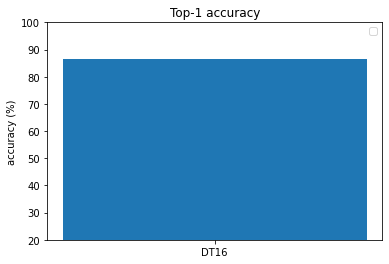

In [14]:
model_names = ['DT16']
accuracy = [dt16_accuracy]

#model_names = ['Mobilenet', 'Inception', 'Resnet', 'LR', 'KNN', 'DT16', 'NB']
# accuracy = [mobilenet_right/len(img_nums), inception_right/len(img_nums),
#             resnet_right/len(img_nums), log_reg_accuracy, knn_accuracy, dt16_accuracy, nb_accuracy]

for i in range(len(accuracy)):
    accuracy[i] = accuracy[i]*100

ypos = np.arange(len(model_names))

plt.xticks(ypos, model_names)
plt.ylabel("accuracy (%)")
plt.title("{} accuracy".format("Top-1"))
plt.bar(ypos, accuracy)
plt.ylim(top = 100)
plt.ylim(bottom = 20)
plt.legend()

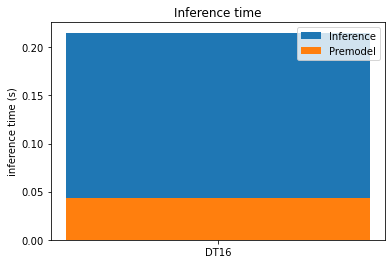

In [15]:
times = [dt16_time]
times_premodel = [dt16_premodel_overhead]

# times = [mobilenet_time/len(img_nums), inception_time/len(img_nums),
#          resnet_time/len(img_nums), log_reg_time, knn_time, dt16_time, nb_time]
# times_premodel = [0, 0, 0, log_reg_premodel_overhead, knn_premodel_overhead, dt16_premodel_overhead, nb_premodel_overhead]

for i in range(len(times)):
    times[i] = times[i]/1000

for i in range(len(times_premodel)):
    times_premodel[i] = times_premodel[i]/1000
    
plt.xticks(ypos, model_names)
plt.ylabel("inference time (s)")
plt.title("Inference time")
plt.bar(ypos, times, label = "Inference")
plt.bar(ypos, times_premodel, label = "Premodel")
plt.legend()